In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.decomposition import PCA

Increase recursion limit to handle large clustering tasks


In [3]:
# Increase recursion limit to handle large clustering tasks
sys.setrecursionlimit(5000)

In [9]:
# Load the gene presence/absence CSV file
gene_presence_absence_df = pd.read_csv('Data/gene_presence_absence_panaroo.csv', index_col=0, low_memory=False)

# Transpose the dataframe to have genomes as rows and genes as columns
data_only_df = gene_presence_absence_df.iloc[:, 2:].T

# Convert presence/absence data to binary (1 if present, 0 if absent)
data_binary_df = data_only_df.notna().astype(int)

print(data_binary_df.head())


Gene              tsaD  yqeY  rplX  rpsU  mdh  typA~~~lepA_1  rplQ  rpoA  \
001SaciDSM13117T     1     1     1     1    1              1     1     1   
002SaciT0_18T        1     1     1     1    1              1     1     1   
003SaciSPDF1         1     1     1     1    1              1     1     1   
004SaciSUNEO         1     1     1     1    1              1     1     1   
005SaciAPG1          1     1     1     1    1              1     1     1   

Gene              rpsD  thrS  ...  group_16  group_13  group_12  group_11  \
001SaciDSM13117T     1     1  ...         0         0         0         0   
002SaciT0_18T        1     1  ...         0         0         0         0   
003SaciSPDF1         1     1  ...         0         0         0         0   
004SaciSUNEO         1     1  ...         0         0         0         0   
005SaciAPG1          1     1  ...         0         0         0         0   

Gene              group_10  group_8  group_5  group_3  group_2  group_0  
001Sac

CREATE CLUSTERMAP

In [10]:
# Create a clustermap, removing the dendrogram above and the names below
clustermap = sns.clustermap(
    data_binary_df,
    cmap='Blues',  # Choose a color palette
    figsize=(20, 30),  # Set figure size
    row_cluster=True,  # Cluster rows
    col_cluster=False,  # Do not cluster columns
    dendrogram_ratio=(.2, 0),  # Adjust the ratio of the dendrogram
    method='average',  # Linkage method to avoid deep recursion with large matrices
)

# Remove the names below (column labels) and above (column dendrogram)
clustermap.ax_heatmap.set_xticklabels([])  # Remove the names below the heatmap

# Remove the color bar (legend)
clustermap.cax.set_visible(False)

# Adjust row labels to make them readable, if necessary
clustermap.ax_heatmap.set_yticklabels(
    clustermap.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)

# Save the clustermap to a file
clustermap.savefig("Outputs/gene_presence_absence_clustermap.png", dpi=300)

plt.close()  # Close the plot to free up memory

c:\Users\josel\Desktop\PlotsSteno\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


PAN-GENOME ANALYSIS

In [14]:
# Calculate the number of genomes
num_genomes = data_binary_df.shape[0]

# Core Genes: present in 99% to 100% of strains
core_genes = data_binary_df.columns[(data_binary_df.sum(axis=0) / num_genomes >= 0.99)].size

# Soft Core Genes: present in 95% to 99% of strains
soft_core_genes = data_binary_df.columns[(data_binary_df.sum(axis=0) / num_genomes >= 0.95) & (data_binary_df.sum(axis=0) / num_genomes < 0.99)].size

# Shell Genes: present in 15% to 95% of strains
shell_genes = data_binary_df.columns[(data_binary_df.sum(axis=0) / num_genomes >= 0.15) & (data_binary_df.sum(axis=0) / num_genomes < 0.95)].size

# Cloud Genes: present in 1% to 15% of strains
cloud_genes = data_binary_df.columns[(data_binary_df.sum(axis=0) / num_genomes >= 0.01) & (data_binary_df.sum(axis=0) / num_genomes < 0.15)].size

# Unique Genes: present in only 1 strain
unique_genes = data_binary_df.columns[(data_binary_df.sum(axis=0) == 1)].size

# Total number of orthologous groups (Pan-genome size)
pan_genome = data_binary_df.shape[1]

# Count unique genes per genome (sum rows where the column sum is 1)
unique_genes_per_genome = data_binary_df.loc[:, data_binary_df.sum(axis=0) == 1].sum(axis=1)

# Convert to DataFrame for exporting
unique_genes_df = pd.DataFrame({
    'Genome': data_binary_df.index,
    'Unique_Genes_Count': unique_genes_per_genome
})

# Save the unique gene counts to a CSV file
unique_genes_df.to_csv('unique_genes_per_genome.csv', index=False)

# If you prefer Excel, use the following:
# unique_genes_df.to_excel('unique_genes_per_genome.xlsx', index=False)

# Print the pan-genome values including unique genes
print(f"Pan-genome size: {pan_genome}")
print(f"Core genes (99% <= strains <= 100%): {core_genes}")
print(f"Soft core genes (95% <= strains < 99%): {soft_core_genes}")
print(f"Shell genes (15% <= strains < 95%): {shell_genes}")
print(f"Cloud genes (1% <= strains < 15%): {cloud_genes}")
print(f"Unique genes (present in only 1 strain): {unique_genes}")
print(f"Unique genes per genome have been saved to 'unique_genes_per_genome.csv'")


Pan-genome size: 50055
Core genes (99% <= strains <= 100%): 57
Soft core genes (95% <= strains < 99%): 149
Shell genes (15% <= strains < 95%): 4155
Cloud genes (1% <= strains < 15%): 24777
Unique genes (present in only 1 strain): 20917
Unique genes per genome have been saved to 'unique_genes_per_genome.csv'


PAN VS CORE GENOME

In [16]:
def calculate_pan_core_genome(df, iterations=500):
    genomes = df.index.tolist()
    core_genome_sizes_list = []
    pan_genome_sizes_list = []

    for _ in range(iterations):
        np.random.shuffle(genomes)  # Shuffle genomes in random order
        core_genome_sizes = []
        pan_genome_sizes = []
        core_genome = set(df.columns)  # Initially assume all orthologs are part of the core
        pan_genome = set()  # Initially empty pan-genome

        for i, genome in enumerate(genomes, start=1):
            genome_orthologs = set(df.columns[df.loc[genome] == 1])
            core_genome = core_genome.intersection(genome_orthologs)
            pan_genome = pan_genome.union(genome_orthologs)
            core_genome_sizes.append(len(core_genome))
            pan_genome_sizes.append(len(pan_genome))

        core_genome_sizes_list.append(core_genome_sizes)
        pan_genome_sizes_list.append(pan_genome_sizes)

    # Convert lists to arrays for easier calculation of mean and std
    core_genome_sizes_array = np.array(core_genome_sizes_list)
    pan_genome_sizes_array = np.array(pan_genome_sizes_list)

    core_genome_mean = core_genome_sizes_array.mean(axis=0)
    core_genome_std = core_genome_sizes_array.std(axis=0)

    pan_genome_mean = pan_genome_sizes_array.mean(axis=0)
    pan_genome_std = pan_genome_sizes_array.std(axis=0)

    return core_genome_mean, core_genome_std, pan_genome_mean, pan_genome_std

# Calculate the pan-genome and core-genome sizes with bootstrapping
core_genome_mean, core_genome_std, pan_genome_mean, pan_genome_std = calculate_pan_core_genome(data_binary_df)

# Generate a plot for pan-genome and core-genome size evolution with error bars
plt.figure(figsize=(10, 6))

# Plot Core Genome Curve with error bars
plt.errorbar(range(1, len(core_genome_mean) + 1), core_genome_mean, yerr=core_genome_std, label='Core Genome',
             color='#2ca02c', marker='o', capsize=4)

# Plot Pan-Genome Curve with error bars
plt.errorbar(range(1, len(pan_genome_mean) + 1), pan_genome_mean, yerr=pan_genome_std, label='Pan-Genome',
             color='#1f77b4', marker='o', capsize=4)

# Plot formatting
plt.xlabel("Nr. of Genomes")
plt.ylabel("Nr. of Genes")
plt.legend()

# Save the plot instead of showing it
plt.savefig("Outputs/pan_core_genome_evolution.png", dpi=300)
plt.close()


PCA analysis

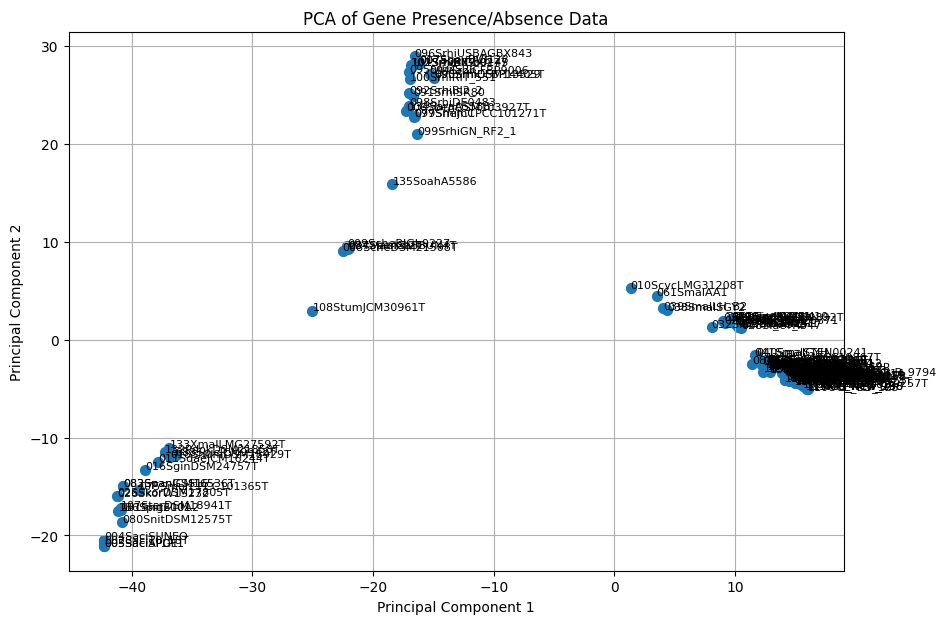

In [10]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_binary_df)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=data_binary_df.index)

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=50)

# Annotate points with genome names (optional, if there are many genomes you might skip this)
for i, genome in enumerate(pca_df.index):
    plt.text(pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], genome, fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Show the plot
plt.show()